# NLP

# 1. ЧБДТ: Что Было До Трансформеров

<img src="attachements/first/nlp_before.png" alt="NLP before meme" width="1000"/>

## План занятий

### 1. ЧБДТ: Что Было До Трансформеров
   1. При чём тут нейро-лингвистическое программирование?
   2. Почему вектора?
   3. Счётные методы: CountVectorizer, TF-IDF, добавляем контекст 
   4. Дистрибутивная семантика: Word2vec, FastText
   5. Рекуррентные нейронные сети: LSTM, GRU
### 2. Трансформеры: база
   1. Мотивация
   2. Attention из all you need?: виды attention, интуиция, реализация
   3. Архитектура Transformer: эмбеддинги, энкодер, декодер
### 3. Трансформеры: на волне хайпа
   1. BERT
   2. GPT
   3. T5

## Краткое введение

### Где используется NLP

#### Поиск

<img src="attachements/first/nlp_examples.png" width="700"/>

### Чат-боты

<img src="attachements/first/ChatGPT.png" width="1200"/>

### Переводчики

<img src="attachements/first/translator.png" width="1200"/>

### Приложения для изучения языков

<img src="attachements/first/duolingo.webp" width="400"/>

<img src="attachements/first/reverso.png" width="1000"/>

### Суммаризация

<img src="attachements/first/Summarizer.png" width="800"/>

## Есть проблемы?

Основная проблема всея ML - классификация. Это верно и для NLP.

Например:
1. Спам или что-то осмысленное?
2. Позитивное или негативное?
3. К какой теме относится?
4. Что от нас хочет пользователь?
5. Токсичность, оскорбления или ок?

Нужно как-то заставить компьютер понимать язык.

## Почему вектора?

<img src="attachements/first/vectors.png" width="800"/>

### Плюсы
1. Понятно для компьютера
2. Хорошо умеем с ними работать (математика + машинное обучение)
3. Можем заложить знания о языке

### Минусы
1. Большое упрощение
2. Неинтерпретируемо (иногда)

## Поехали...

In [1]:
%%capture
%pip install openpyxl pandas torch transformers pymorphy3 pymorphy3-dicts-ru navec
%pip install scikit-learn nltk matplotlib seaborn gensim

In [2]:
%%capture
!wget -nc https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [3]:
%%capture
import nltk; nltk.download("stopwords")

In [31]:
import random
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
seed_everything(0)

In [5]:
import warnings
warnings.filterwarnings("ignore")

## Счётные методы + предобработка текста

### Основная идея
Считаем все слова в тексте; представляем текст как вектор (1 х V), где V - размер словаря (количество уникальных слов во всех текстах выборки). 

Например: Моя мама мыла раму. Раму мыла мама, мама.

||моя|мама|мыла|раму|
|-|-|-|-|-|
|1.|1|1|1|1|
|2.|0|2|1|1|

В scikit-learn для этого существует `CountVectorizer`.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import re

In [7]:
micro_dataset = ["моя мама мыла раму", "раму мыла мама, мама"]

#### Токенизация

**Токенизатор** - это программа или алгоритм, который разбивает текст на отдельные единицы, называемые токенами. \
Токены могут быть словами, символами, знаками препинания или другими элементами, которые важны для нашей задачи.

Напишем свой собственный токенизатор!

*(а можно было взять уже готовый из [razdel](https://github.com/natasha/razdel), spacy, nltk, ...)*

<img src="attachements/first/tokenizers.png" width="800"/>

In [8]:
tokenization_regex = re.compile(r"[\w]+")

def tokenize(text: str) -> list[str]:
    return re.findall(tokenization_regex, text)

In [9]:
tokenized_micro_dataset = list(map(tokenize, micro_dataset))
tokenized_micro_dataset

[['моя', 'мама', 'мыла', 'раму'], ['раму', 'мыла', 'мама', 'мама']]

In [10]:
?CountVectorizer

Init signature:
CountVectorizer(
    *,
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words=None,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 1),
    analyzer='word',
    max_df=1.0,
    min_df=1,
    max_features=None,
    vocabulary=None,
    binary=False,
    dtype=<class 'numpy.int64'>,
)
Docstring:     
Convert a collection of text documents to a matrix of token counts.

This implementation produces a sparse representation of the counts using
scipy.sparse.csr_matrix.

If you do not provide an a-priori dictionary and you do not use an analyzer
that does some kind of feature selection then the number of features will
be equal to the vocabulary size found by analyzing the data.

For an efficiency comparision of the different feature extractors, see
:ref:`sphx_glr_auto_examples_text_plot_hashing_vs_dict_vectorizer.py`.

Read more in the :ref:`User Guid

In [11]:
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
vectors = vectorizer.fit_transform(tokenized_micro_dataset)
pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

,мама,моя,мыла,раму
0,1,1,1,1
1,2,0,1,1


### Вопрос

Какая проблема будет для предложения "Мы увидели зеленый стол, подошли к зеленому столу, пододвинули другие зелёные столы."?

### Решение

#### Лемматизация
**Лемматизация** - приведение слов в нормальную форму. \
Нормальная форма обычно является именительным падежом единственного числа для существительных, инфинитивом для глаголов, мужским родом для прилагательных и т.д. Лемматизация учитывает морфологические и синтаксические особенности языка и пытается сохранить смысл слова. 

Есть ещё **стемминг** - удаление суффиксов/окончаний, чтобы получить его основу или корень. \
Основа или корень не обязательно является нормальной формой или даже существующим словом, а просто общим элементом для группы слов.

Лемматизированный текст: мы увидеть зеленый стол, подойти к зеленый стол, пододвинуть другой зеленый стол. \
Стеммированный текст: мы увид зелен стол, подошл к зелен стол, пододвин друг зелен стол.

Для русского обычно используют лемматизацию. В питоне с помощью библиотек: pymorphy2/3, natasha, rmmnorph, spacy, ...

In [12]:
import pymorphy3

morph = pymorphy3.MorphAnalyzer()

def lemmatize(word: str) -> str:
    return morph.parse(word)[0].normal_form

In [13]:
list(map(lambda x: list(map(lemmatize, x)), tokenized_micro_dataset))

[['мой', 'мама', 'мыло', 'рама'], ['рама', 'мыло', 'мама', 'мама']]

### Вопрос

Какая будет проблема, если тексты будут очень разной длины?

### Решение

Проблема - частоты слов будут несопоставимы. \
Решение - используем бинарный векторайзер: ставим 1, если слово встретилось хотя бы один раз; ставим 0, если слова не было в тексте.

In [14]:
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, binary=True)
vectors = vectorizer.fit_transform(tokenized_micro_dataset)
pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

,мама,моя,мыла,раму
0,1,1,1,1
1,1,0,1,1


### Вопрос

Какие ещё проблемы будут?

### Подсказка

#### Закон Ципфа

Частота слова в языке обратно пропорциональна порядковому номеру этого слова.

<img src="attachements/first/zipf.png" width="800"/>

### Решение

Проблема - самые частотные слова будут встречаться чаще всего.

#### Стоп-слова

Cтоп-слова - слова, которые бесполезны для решения задачи, мусорные слова. Часто - достаточно частотные в языке.

In [15]:
from nltk.corpus import stopwords as stopwords_nltk

stopwords = stopwords_nltk.words('russian')
stopwords = [w for w in stopwords if w not in ['не', 'нет', 'я']]
print(stopwords)

['и', 'в', 'во', 'что', 'он', 'на', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впрочем', 'хорошо', '

In [16]:
def is_meaningful(word: str) -> bool:
    return word not in stopwords

#### Финальный пайплайн предобработки текста:

1. Привести к нижнему регистру
2. Токенизировать
3. Лемматизировать
4. Убрать стоп-слова

В зависимости от вашей задачи и используемых методов - пайплайн может меняться.

In [17]:
def preprocess_text(text: str) -> list[str]:
    text = text.lower()
    tokens = tokenize(text)
    lemmas = map(lemmatize, tokens)
    lemmas_meaningful = filter(is_meaningful, lemmas)

    return list(lemmas_meaningful)

In [18]:
preprocess_text("Зелёная трава зеленила зелёную траву!")

['зелёный', 'трава', 'зеленить', 'зелёный', 'трава']

#### TF-IDF

Основная идея: перевзвесить слова таким образом, чтобы частотным словам (которые встречаются в большом количестве документов)
придать вес поменьше, а редким (специфическим для определенных текстов) словам - побольше.

<img src="attachements/first/tfidf.png" width="800"/>

Почему в формуле логарифм?

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectors = vectorizer.fit_transform(tokenized_micro_dataset)
pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

,мама,моя,мыла,раму
0,0.448321,0.630099,0.448321,0.448321
1,0.816497,0.000000,0.408248,0.408248


In [21]:
micro_dataset

['моя мама мыла раму', 'раму мыла мама, мама']

Обычно TF-IDF оказывается лучше других счётных методов, но иногда и другие стреляют.

### Вопрос

Есть ли ещё проблемы?

### Подсказка

Как будут представлены предложения "я тебя не люблю" и "я люблю не тебя"?

### Решение

Добавляем контекстуальность через би-, три- и тд-граммы!

<img src="attachements/first/ngrams.png" width="800"/>

In [22]:
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, ngram_range=(1, 3))
vectors = vectorizer.fit_transform(tokenized_micro_dataset)
pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

,мама,мама мама,мама мыла,мама мыла раму,моя,моя мама,моя мама мыла,мыла,мыла мама,мыла мама мама,мыла раму,раму,раму мыла,раму мыла мама
0,1,0,1,1,1,1,1,1,0,0,1,1,0,0
1,2,1,0,0,0,0,0,1,1,1,0,1,1,1


### Вопрос

Как будем решать проблему с огромной размерностью получившейся матрицы?

### Ответ

1. Обрезать совсем редкие н-граммы или токены
2. Снижать размерность

## Практика!

In [23]:
with open("dataset.txt")as file:
    data = file.read().split("\n")[:-1]
    data = list(map(lambda x: x.split(" ", maxsplit=1), data))
    data = pd.DataFrame(data, columns=["target", "text"])

In [24]:
data.head()

,target,text
0,__label__INSULT,скотина! что сказать
1,__label__NORMAL,я сегодня проезжала по рабочей и между домами ...
2,__label__NORMAL,очередной лохотрон. зачем придумывать очередно...
3,__label__NORMAL,"ретро дежавю ... сложно понять чужое сердце , ..."
4,__label__NORMAL,а когда мы статус агрогородка получили?


In [25]:
data["target"].value_counts()

target
__label__NORMAL                                       203685
__label__INSULT                                        28567
__label__INSULT,__label__THREAT                         6317
__label__THREAT                                         5460
__label__OBSCENITY                                      2245
__label__INSULT,__label__OBSCENITY                      1766
__label__INSULT,__label__OBSCENITY,__label__THREAT       176
__label__OBSCENITY,__label__THREAT                        74
Name: count, dtype: int64

In [26]:
data["target"] = data["target"] \
    .apply(lambda x: "__label__OBSCENITY" if "OBSCENITY" in x else x) \
    .apply(lambda x: "__label__THREAT" if "THREAT" in x else x)

In [27]:
data["target"].value_counts()

target
__label__NORMAL       203685
__label__INSULT        28567
__label__THREAT        11777
__label__OBSCENITY      4261
Name: count, dtype: int64

In [28]:
data = data.sample(frac=1).groupby("target").head(6666).reset_index(drop=True)

In [29]:
data["target"].value_counts()

target
__label__INSULT       6666
__label__NORMAL       6666
__label__THREAT       6666
__label__OBSCENITY    4261
Name: count, dtype: int64

In [30]:
data["target"] = data["target"].factorize()[0]

In [31]:
data.head()

,target,text
0,0,"это твоя мама толстая все сжирает,а у путьки н..."
1,1,правда на 100% . прежде чем что то требовать н...
2,0,"все правильно не уступай трамваю, и поездам то..."
3,2,"таких людей убивать нужно, бедный ребёнок, сер..."
4,1,"опять театр опять развлекуха!! опять клоуны, а..."


In [32]:
from tqdm import tqdm

tqdm.pandas()

In [33]:
data["processed_text"] = data["text"].progress_apply(preprocess_text)

  0%|          | 0/24259 [00:00<?, ?it/s]

100%|██████████| 24259/24259 [00:19<00:00, 1246.75it/s]


In [34]:
data.head(5)

,target,text,processed_text
0,0,"это твоя мама толстая все сжирает,а у путьки н...","[это, твой, мама, толстой, всё, сжирать, путьк..."
1,1,правда на 100% . прежде чем что то требовать н...,"[правда, 100, прежде, требовать, дать, вложиться]"
2,0,"все правильно не уступай трамваю, и поездам то...","[всё, правильно, не, уступать, трамвай, поезд,..."
3,2,"таких людей убивать нужно, бедный ребёнок, сер...","[человек, убивать, нужно, бедный, ребёнок, сер..."
4,1,"опять театр опять развлекуха!! опять клоуны, а...","[театр, развлекуха, клоун, рабочий, класс, сел..."


In [35]:
data["processed_text"].str.len().describe(percentiles=[0.99])

count    24259.000000
mean         8.337483
std          9.629260
min          0.000000
50%          5.000000
99%         51.000000
max        155.000000
Name: processed_text, dtype: float64

In [36]:
data = data[data["processed_text"].apply(len) >= 3].reset_index(drop=True)
data["processed_text"] = data["processed_text"].apply(lambda x: x[:50])

In [37]:
data["target"].value_counts()

target
0    5714
2    5502
1    5385
3    3580
Name: count, dtype: int64

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
train_data, test_data = train_test_split(data, test_size=0.15, stratify=data["target"])

In [41]:
X_train, X_test = train_data["processed_text"].values, test_data["processed_text"] 
y_train, y_test = train_data["target"].values, test_data["target"].values

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

model = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 1), 
        max_features=10000,  # Взяли с потолка!
        tokenizer=lambda x: x, 
        lowercase=False
    )),
    ('svm',  LinearSVC())
])

In [43]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_features=10000,
                                 tokenizer=<function <lambda> at 0x296c38a40>)),
                ('svm', LinearSVC())])

In [44]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred, average='macro'):
    precision = precision_score(y_true, y_pred, average=average, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    print(f'{average.capitalize()} Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}')

    return precision, recall, f1

In [46]:
compute_metrics(y_train, pred_train);

Macro Precision = 0.9706, Recall = 0.9702, F1 = 0.9704


In [47]:
compute_metrics(y_test, pred_test);

Macro Precision = 0.8261, Recall = 0.8224, F1 = 0.8238


## Дистрибутивная семантика

### Задача
Получить "экспрессивные" вектора для слов.
### Идея
Значение слова определяется его контекстом. Значит, нужно заложить информацию о возможных контекстах в вектор слова.

<img src="attachements/first/distributional_semantics.png" width="800"/>

## Word2vec

Нейронная сеть, параметры которой - вектора слов. Вектора обновляются итеративно, как при обучении любой нейронки.

 - Учим модель предсказывать слова контекста по центральному слову (было слово в контексте или нет) - **Skip-gram**
 - Либо наоборот! Предсказывать слово по контексту (было слово в центре или нет) - **CBOW**

Пайплайн обучения:
* Берём огромный корпус текстов (без разметки - self-supervised learning!)
* Шагаем по текстам, слово за словом. На каждом шаге смотрим на центральное слово и контекст (заданного размера)
* Смотря на центральное слово, считаем вероятности того, что слово из контекста находится радом с центральным словом - **Skip-gram**
  * Либо наоборот! Смотрим на слова контекста, считаем вероятности того, что центральное слово находится рядом с контекстами - **CBOW**
* Изменяем вектора, чтобы увеличить эту вероятность (бэк-проп, градиентный спуск, все дела)

<img src="attachements/first/w2v_training.png" width="800"/>

### Лосс


### CBOW vs Skip-gram

<img src="attachements/first/cbow_skipgram.webp" width="800"/>

### Вопрос
Какие преимущества у каждого из методов в каких ситуациях?

### Плюсы CBOW

- Лучше для частотных слов (почему?)
- Лучше учит синтаксические связи (кот и коты ближе друг к другу)
- Учится быстрее

### Плюсы Skip-gram

- Меньше переобучается на частотные слова
- Лучше выражает редкие слова
- Требует меньше данных

### Интуиция и прикольные свойства

<img src="attachements/first/w2v_properties.jpg" width="800"/>

In [4]:
from navec import Navec

navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [87]:
navec_embeddings = torch.from_numpy(np.stack(list(map(navec.get, navec.vocab.words[:-2]))))
navec_embeddings = torch.nn.functional.normalize(navec_embeddings, dim=-1)

idx_to_word = dict(enumerate(navec.vocab.words[:-2]))

In [88]:
import pandas as pd

In [105]:
def find_closest(word, top_k=5):
    embedding = torch.nn.functional.normalize(torch.from_numpy(navec[word]), dim=0)
    
    sim = embedding @ navec_embeddings.T
    idx = sim.topk(top_k + 1).indices

    top_sim = sim[idx][1:].tolist()
    top_words = [idx_to_word[i] for i in idx.tolist()[1:]]

    return pd.DataFrame(zip(top_words, top_sim), columns=["word", "similarity"])

In [111]:
find_closest("кот")

,word,similarity
0,кошка,0.671421
1,котенок,0.656233
2,пес,0.650454
3,кота,0.646174
4,рыжий,0.611956


In [116]:
find_closest("мелкий")

,word,similarity
0,дождик,0.670390
1,моросящий,0.615993
2,дождичек,0.612513
3,моросил,0.574571
4,дождь,0.557204


In [ ]:
def compare_three():
    pass

In [6]:
navec.sim("постель", "кровать")

0.7520469

### За и против

#### Плюсы
- Репрезентации слов, понимающие отношения и характеристики реального мира
- Можно брать и использовать!

#### Минусы
- Неинтерпретируемы
- Есть проблемы с разными значениями слов
- Есть out-of-vocabulary слова: новые слова, редкие слова, опечатки

### Козыри

А что если брать эмбеддинги последовательностей букв?

<img src="attachements/first/fasttext.png" width="800"/>

Проблема с out-of-vocabulary частично решается.

In [37]:
def vectorize(text: list[str], mean=True) -> np.ndarray:
    embeddings = [navec.get(x, navec['<unk>']) for x in text]
    
    if mean:
        return np.stack(embeddings).mean(axis=0)
    else:
        return np.stack(embeddings)

In [38]:
X_train = np.stack(train_data["processed_text"].apply(vectorize))
X_test = np.stack(test_data["processed_text"].apply(vectorize))

In [39]:
X_train.shape

(17153, 300)

In [114]:
from sklearn.linear_model import LogisticRegression

In [40]:
logreg = LogisticRegression(max_iter=300)

In [41]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [42]:
pred_train = logreg.predict(X_train)
pred_test = logreg.predict(X_test)

In [43]:
compute_metrics(y_train, pred_train);

Macro Precision = 0.7809, Recall = 0.7689, F1 = 0.7734


In [44]:
compute_metrics(y_test, pred_test);

Macro Precision = 0.7412, Recall = 0.7325, F1 = 0.7360


# RNNs

In [51]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
from operator import itemgetter
import torch.optim as optim

from functools import partial, reduce
from collections import Counter

In [52]:
sorted_idx = train_data["processed_text"].str.len().sort_values().index

In [53]:
train_data = train_data.loc[sorted_idx]
y_train = train_data["target"].values

In [54]:
X_train = train_data["processed_text"].values
X_test = test_data["processed_text"].values

In [55]:
c = Counter(reduce(lambda x, y: x + y, X_train))
c.most_common(10000)

[('не', 6036),
 ('я', 2924),
 ('это', 2701),
 ('всё', 1623),
 ('весь', 1424),
 ('свой', 1224),
 ('человек', 903),
 ('тварь', 902),
 ('ещё', 800),
 ('сука', 781),
 ('хуй', 703),
 ('твой', 680),
 ('мочь', 658),
 ('d', 623),
 ('сосать', 607),
 ('ребёнок', 590),
 ('нет', 583),
 ('мразь', 566),
 ('пидор', 550),
 ('хотеть', 525),
 ('жопа', 525),
 ('хороший', 511),
 ('урод', 509),
 ('который', 508),
 ('народ', 468),
 ('просто', 465),
 ('год', 455),
 ('наш', 446),
 ('блядь', 446),
 ('россия', 429),
 ('нужно', 425),
 ('расстрелять', 415),
 ('дать', 394),
 ('жить', 392),
 ('пусть', 390),
 ('знать', 389),
 ('рука', 387),
 ('идти', 352),
 ('путин', 347),
 ('ваш', 344),
 ('жизнь', 342),
 ('страна', 337),
 ('рот', 326),
 ('сказать', 320),
 ('очень', 320),
 ('большой', 317),
 ('кол', 300),
 ('говорить', 298),
 ('день', 288),
 ('убить', 287),
 ('место', 286),
 ('делать', 280),
 ('ублюдок', 265),
 ('б', 262),
 ('слово', 254),
 ('деньга', 254),
 ('её', 253),
 ('думать', 241),
 ('вообще', 240),
 ('писать

In [56]:
len(c.keys())

26735

In [63]:
word_dist = pd.Series(c).sort_values(ascending=False).head(150)

<Axes: >

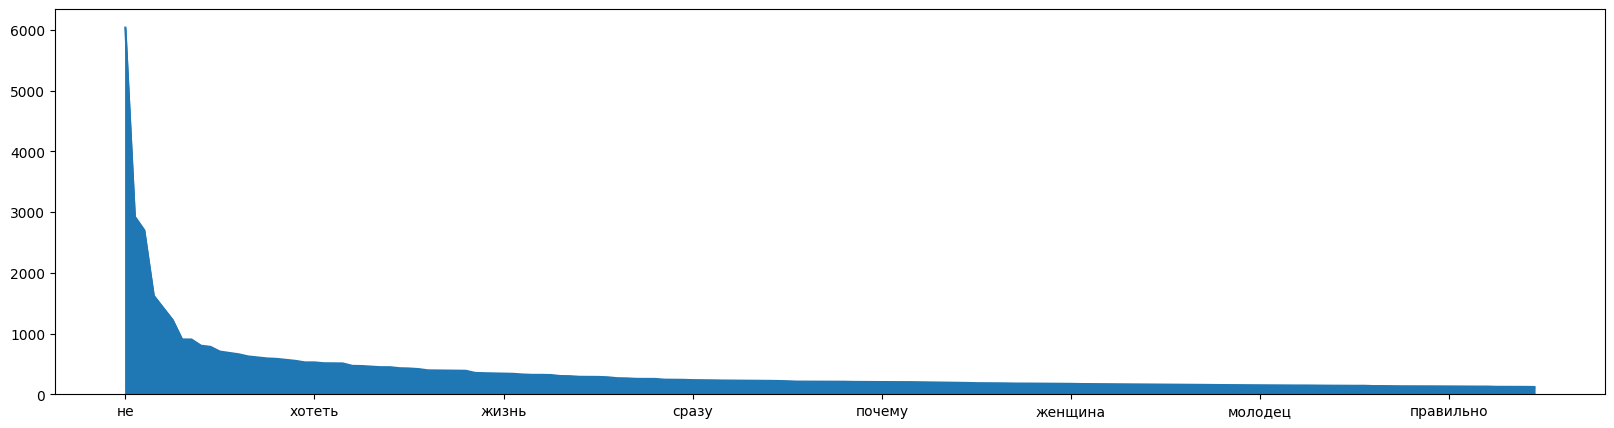

In [64]:
word_dist.plot.area(figsize=(20, 5))

In [53]:
cumsums = (word_dist / c.total()).cumsum().reset_index(name="cumsum")

In [54]:
len(cumsums.query("cumsum <= 0.50"))

522

In [55]:
vocab_size = len(cumsums.query("cumsum <= 0.9")) 
print(vocab_size)

10479


In [56]:
vocab = ["<UNK>"] + cumsums["index"].iloc[0:vocab_size].tolist()

In [57]:
word2idx = dict(zip(vocab, range(len(vocab))))

In [58]:
BATCH_SIZE = 1024
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 300
NUM_CLASSES = 4
NUM_EPOCHS = 5
NUM_LAYERS = 3
LEARNING_RATE = 5e-3
DEVICE = torch.device("cpu")

In [59]:
class BiLstmForClassification(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes) -> None:
        super().__init__()

        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.lstm = nn.LSTM(
            input_size=emb_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            bidirectional=True, 
            batch_first=True
        )
        self.ff = nn.Linear(hidden_size * 2, num_classes)

        self.embedding = None
        self._word2idx = None
        self._embed = None

    def forward(self, texts):
        if self._embed is None:
            raise NotImplementedError("You forgot to init embeddings.")

        embeddings = self._embed(texts)
        embeddings = self._prepare_embeddings(embeddings)

        out, (hidden, cell) = self.lstm(embeddings)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)

        return self.ff(hidden)

    def init_embeddings(self, learn_embeddings, **kwargs):
        if learn_embeddings:
            self._word2idx = kwargs["word2idx"]

            embedding_matrix = self._init_embedding_matrix()
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
            self._embed = self._embed_self
        else:
            self._embed = self._embed_navec
    
    def _init_embedding_matrix(self):
        vocab_size = len(self._word2idx)
        init_matrix = np.random.rand(vocab_size, self.emb_size)

        for word, idx in self._word2idx.items():
            navec_emb = navec.get(word)
            if navec_emb is not None:
                init_matrix[idx] = navec_emb
        
        return torch.from_numpy(init_matrix).to(torch.float32)

    def _embed_self(self, texts: list[list[str]]) -> list[torch.Tensor]:
        ids = list(map(self._convert_words2idx, texts))
        embeddings = list(map(self.embedding, ids))

        return embeddings

    def _convert_words2idx(self, text: list[str]) -> list[int]:
        encoded = [self._word2idx.get(w, self._word2idx["<UNK>"]) for w in text]
        return torch.tensor(encoded, dtype=torch.int)

    @staticmethod
    def _embed_navec(texts: list[list[str]]) -> list[torch.Tensor]:
        embeddings = list(map(partial(vectorize, mean=False), texts))
        embeddings = list(map(torch.from_numpy, embeddings))

        return embeddings

    @staticmethod
    def _prepare_embeddings(embeddings: list[torch.Tensor]):
        lengths = list(map(len, embeddings))

        embeddings = nn.utils.rnn.pad_sequence(embeddings, batch_first=True)
        embeddings = nn.utils.rnn.pack_padded_sequence(
            embeddings, lengths, batch_first=True, enforce_sorted=False
        )

        return embeddings.to(DEVICE)

In [60]:
class LstmDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [61]:
def collate(batch):
    texts = list(map(itemgetter(0), batch))
    labels = list(map(itemgetter(1), batch))

    labels = torch.tensor(labels)

    return texts, labels

In [62]:
train_dataset = LstmDataset(X_train, y_train)
test_dataset = LstmDataset(X_test, y_test)

In [63]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)

In [64]:
lstm = BiLstmForClassification(EMBEDDING_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES)
lstm.init_embeddings(learn_embeddings=False, word2idx=word2idx)
lstm.to(DEVICE)

BiLstmForClassification(
  (lstm): LSTM(300, 300, num_layers=3, batch_first=True, bidirectional=True)
  (ff): Linear(in_features=600, out_features=4, bias=True)
)

In [65]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=LEARNING_RATE)

/Users/aleksiej/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
def train_epoch():
    lstm.train()

    losses = []
    for texts, labels in tqdm(train_dataloader, total=len(train_dataloader)):
        labels = labels.to(DEVICE)

        outputs = lstm(texts)

        loss = loss_func(outputs, labels)

        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        optimizer.zero_grad()

    epoch_loss = sum(losses) / len(losses)

    return epoch_loss

In [67]:
@torch.no_grad()
def test_epoch():
    lstm.eval()

    losses = []
    predictions = []
    for texts, labels in tqdm(test_dataloader, total=len(test_dataloader)):
        labels = labels.to(DEVICE)

        outputs = lstm(texts)

        loss = loss_func(outputs, labels)
        pred_labels = outputs.argmax(dim=1).tolist()

        predictions.extend(pred_labels)
        losses.append(loss.item())

    epoch_loss = sum(losses) / len(losses)
    
    return epoch_loss, predictions

In [68]:
def train_model():
    for epoch in range(NUM_EPOCHS):
        train_loss = train_epoch()
        test_loss, pred_test = test_epoch()

        print(f"TRAIN Epoch {epoch+1}, Loss: {train_loss:.4f}")
        print(f"TEST Epoch {epoch+1}, Loss: {test_loss:.4f}")

        compute_metrics(y_test, pred_test)
        print()
    
    return pred_test 

In [69]:
pred_test = train_model()

100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


TRAIN Epoch 1, Loss: 1.1479
TEST Epoch 1, Loss: 0.8183
Macro Precision = 0.7066, Recall = 0.6819, F1 = 0.6846



100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


TRAIN Epoch 2, Loss: 0.7020
TEST Epoch 2, Loss: 0.7368
Macro Precision = 0.7478, Recall = 0.7562, F1 = 0.7491



100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


TRAIN Epoch 3, Loss: 0.5903
TEST Epoch 3, Loss: 0.5957
Macro Precision = 0.8003, Recall = 0.7702, F1 = 0.7804



100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


TRAIN Epoch 4, Loss: 0.5277
TEST Epoch 4, Loss: 0.6012
Macro Precision = 0.7851, Recall = 0.7864, F1 = 0.7819



100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

TRAIN Epoch 5, Loss: 0.4901
TEST Epoch 5, Loss: 0.6092
Macro Precision = 0.8117, Recall = 0.7643, F1 = 0.7757



In [70]:
lstm = BiLstmForClassification(EMBEDDING_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES)
lstm.init_embeddings(learn_embeddings=True, word2idx=word2idx)
lstm.to(DEVICE)

BiLstmForClassification(
  (lstm): LSTM(300, 300, num_layers=3, batch_first=True, bidirectional=True)
  (ff): Linear(in_features=600, out_features=4, bias=True)
  (embedding): Embedding(10480, 300)
)

In [71]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=LEARNING_RATE)

In [72]:
pred_test = train_model()

100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


TRAIN Epoch 1, Loss: 1.1721
TEST Epoch 1, Loss: 0.7878
Macro Precision = 0.7737, Recall = 0.6746, F1 = 0.6839



100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


TRAIN Epoch 2, Loss: 0.5975
TEST Epoch 2, Loss: 0.6124
Macro Precision = 0.7741, Recall = 0.7895, F1 = 0.7678



100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


TRAIN Epoch 3, Loss: 0.3817
TEST Epoch 3, Loss: 0.5007
Macro Precision = 0.8417, Recall = 0.8158, F1 = 0.8244



100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


TRAIN Epoch 4, Loss: 0.2498
TEST Epoch 4, Loss: 0.5869
Macro Precision = 0.8119, Recall = 0.8201, F1 = 0.8013



100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

TRAIN Epoch 5, Loss: 0.1808
TEST Epoch 5, Loss: 0.5399
Macro Precision = 0.8547, Recall = 0.8320, F1 = 0.8397



### Не нужно забывать базу!